## Example of how to find the nearest green area using the GreenAreaFinder class

#### Find the nearest green area from a starting point

Authenticated using refresh token.
Coordinates for the starting point: 45.0813291 7.6675035
Coordinates for the nearest green area: 45.08174588513514, 7.668085905052784
Estimated time to the nearest green area: 0.9 minutes
Distance to the nearest green area: 0.0629 km


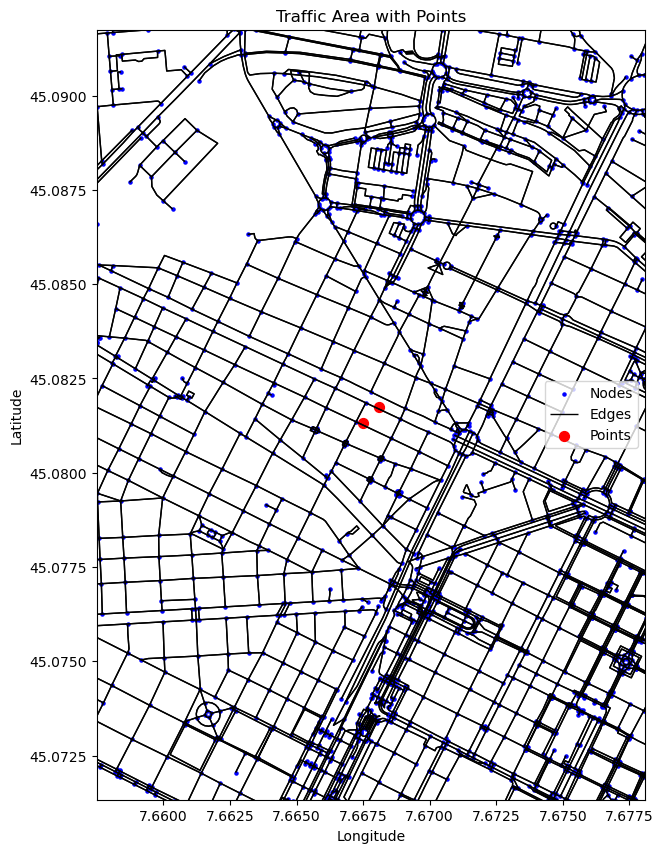

In [4]:
from data.boundingbox.BoundingBox import BoundingBox
from data.downloader.CopernicusDownloader import CopernicusDownloader
from data.downloader.OSMDownloader import OSMDownloader
from data.utils.LandUtils import LandUtils
from data.utils.GreenAreaFinderCopernicus import GreenAreaFinder
from data.downloader.GHSPOPDownloader import GHSPOPDownloader
import json
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

copernicus_downloader = CopernicusDownloader(
        client_id="sh-a24a739d-d123-419b-a409-81a190c436c2",
        client_secret="dcUnE32uBB1gLvlxyi3qOeUPdGGpNMRs",
        token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'
    )

bbox = BoundingBox()
bounding_box = bbox.get_bounding_box(query="Piazza Castello, Torino", method="from_center_radius", radius_km=15)
# we are using the "from_center_radius" method to get the bounding box coordinates, it gets the bounding box from a center point and a radius in km
# different methods are available to get the bounding box coordinates, such as "from_coordinates" and "from_geojson"

copernicus_area = copernicus_downloader.download_raster_area(
    bounding_box,
    use_oidc=False
)

# use_oidc=False indicates we are using the client_id and client_secret for authentication
# with use_oidc=True, we would use the OpenID Connect authentication method

osm_area = OSMDownloader()
osm_area = osm_area.get_traffic_area(
    bounding_box=bounding_box,
    network_type="walk"
)
ghspop = GHSPOPDownloader(
        address="Piazza Castello, Torino",
        shapefile="../../tiling_schema/WGS84_tile_schema.shp"
    )
ghspop_area = ghspop.get_population_area(bounding_box)
ghs_pop_resized = LandUtils().adjust_detail_level(copernicus_area, ghspop_area) # need to adjust the detail level of the GHSPOP data to match the Copernicus data

address = "Via Principessa Clotilde 28/B, Torino"
lat, lon = LandUtils().get_coordinates_from_address(address) #need to convert the address to coordinates


green_area_finder = GreenAreaFinder(
    copernicus_area,
    osm_area,
    ghs_pop_resized,
)

print("Coordinates for the starting point:", lat, lon)
distance = green_area_finder.direction_to_green(lat, lon, "walk")   # possibility to give specific green_area bands
# get the direction to the nearest green area from the starting point
# starts using get_nearest_green_position, then get the direction to the nearest green area
distance = json.loads(distance)
minute = distance['estimated_time_minutes']
distance_km = distance['distance_km']
green_lat = distance['lat']
green_lon = distance['lon']
print(f"Coordinates for the nearest green area: {green_lat}, {green_lon}")
print(f"Estimated time to the nearest green area: {minute} minutes")
print(f"Distance to the nearest green area: {distance_km} km")


point1=(lat, lon)
point2=(green_lat, green_lon)
nodes, edges = green_area_finder.vector_traffic_area
points_gdf = gpd.GeoDataFrame(geometry=[Point(point1[1], point1[0]), Point(point2[1], point2[0])], crs=nodes.crs)
minx, miny = min(point1[1], point2[1]), min(point1[0], point2[0])
maxx, maxy = max(point1[1], point2[1]), max(point1[0], point2[0])
buffer = 0.01

fig, ax = plt.subplots(figsize=(10, 10))
nodes.plot(ax=ax, color='blue', markersize=5, label='Nodes')
edges.plot(ax=ax, color='black', linewidth=1, label='Edges')
points_gdf.plot(ax=ax, color='red', markersize=50, label='Points')

# Set plot limits to the bounding box
ax.set_xlim(minx - buffer, maxx + buffer)
ax.set_ylim(miny - buffer, maxy + buffer)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Traffic Area with Points')
plt.show()

#### Find the green area per person ratio in the bounding box

In [1]:
from data.boundingbox.BoundingBox import BoundingBox
from data.downloader.CopernicusDownloader import CopernicusDownloader
from data.downloader.OSMDownloader import OSMDownloader
from data.utils.LandUtils import LandUtils
from data.utils.GreenAreaFinderCopernicus import GreenAreaFinder
from data.downloader.GHSPOPDownloader import GHSPOPDownloader

copernicus_downloader = CopernicusDownloader(
        client_id="sh-a24a739d-d123-419b-a409-81a190c436c2",
        client_secret="dcUnE32uBB1gLvlxyi3qOeUPdGGpNMRs",
        token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'
    )

bbox = BoundingBox()
bounding_box = bbox.get_bounding_box(query="Piazza Castello, Torino", method="from_center_radius", radius_km=15)
# we are using the "from_center_radius" method to get the bounding box coordinates, it gets the bounding box from a center point and a radius in km
# different methods are available to get the bounding box coordinates, such as "from_coordinates" and "from_geojson"

copernicus_area = copernicus_downloader.download_raster_area(
    bounding_box,
    use_oidc=False
)
# use_oidc=False indicates we are using the client_id and client_secret for authentication
# with use_oidc=True, we would use the OpenID Connect authentication method

osm_area = OSMDownloader()
osm_area = osm_area.get_traffic_area(
    bounding_box=bounding_box,
    network_type="walk"
)
ghspop = GHSPOPDownloader(
        address="Piazza Castello, Torino",
        shapefile="../../tiling_schema/WGS84_tile_schema.shp"
    )
ghspop_area = ghspop.get_population_area(bounding_box)
ghs_pop_resized = LandUtils().adjust_detail_level(copernicus_area, ghspop_area) # need to adjust the detail level of the GHSPOP data to match the Copernicus data

green_area_finder = GreenAreaFinder(
    copernicus_area,
    osm_area,
    ghs_pop_resized,
)
population_green_ratio = green_area_finder.green_area_per_person() # option: possibility to give the bands of the copernicus data for the green areas
print(f"Green area / population: {population_green_ratio}")

Authenticated using refresh token.
Green area / population: 3.5691


In [4]:
from data.boundingbox.BoundingBox import BoundingBox
from data.downloader.CopernicusDownloader import CopernicusDownloader
from data.downloader.OSMDownloader import OSMDownloader
from data.utils.LandUtils import LandUtils
from data.utils.GreenAreaFinderCopernicus import GreenAreaFinder
from data.downloader.GHSPOPDownloader import GHSPOPDownloader

copernicus_downloader = CopernicusDownloader(
        client_id="sh-a24a739d-d123-419b-a409-81a190c436c2",
        client_secret="dcUnE32uBB1gLvlxyi3qOeUPdGGpNMRs",
        token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'
    )

bbox = BoundingBox()
bounding_box = bbox.get_bounding_box(query="Piazza Castello, Torino", method="from_center_radius", radius_km=15)
# we are using the "from_center_radius" method to get the bounding box coordinates, it gets the bounding box from a center point and a radius in km
# different methods are available to get the bounding box coordinates, such as "from_coordinates" and "from_geojson"

copernicus_area = copernicus_downloader.download_raster_area(
    bounding_box,
    use_oidc=False
)
# use_oidc=False indicates we are using the client_id and client_secret for authentication
# with use_oidc=True, we would use the OpenID Connect authentication method

osm_area = OSMDownloader()
osm_area = osm_area.get_traffic_area(
    bounding_box=bounding_box,
    network_type="walk"
)
ghspop = GHSPOPDownloader(
        address="Piazza Castello, Torino",
        shapefile="../../tiling_schema/WGS84_tile_schema.shp"
    )
ghspop_area = ghspop.get_population_area(bounding_box)
ghs_pop_resized = LandUtils().adjust_detail_level(copernicus_area, ghspop_area) # need to adjust the detail level of the GHSPOP data to match the Copernicus data

green_area_finder = GreenAreaFinder(
    copernicus_area,
    osm_area,
    ghs_pop_resized,
)
address = "Via Antonio Bertola 48/C, Torino"
lat, lon = LandUtils().get_coordinates_from_address(address) #need to convert the address to coordinates
transport_mode = "walk"
time_max = 12
isochrone_area = green_area_finder.get_isochrone_green(lat, lon, time_max, transport_mode) # get the green area reachable in a certain time from the starting point
isochrone_area = json.loads(isochrone_area)
green_area_percentage = isochrone_area["green_area_percentage"]
areasq = isochrone_area["green_area_sqm"]
print(f"MAX AREA REACHABLE WITH {transport_mode} IN {time_max} MINUTES")
print(f"\t- Green area percentage: {green_area_percentage}%")
print(f"\t- Green area traversed: {areasq} sqm")

Authenticated using refresh token.
MAX AREA REACHABLE WITH walk IN 12 MINUTES
	- Green area percentage: 13.01%
	- Green area traversed: 23400 sqm


#### Get the land use percentages in the bounding box

In [9]:
from data.boundingbox.BoundingBox import BoundingBox
from data.downloader.CopernicusDownloader import CopernicusDownloader
from data.utils.LandUseAnalyzer import LandUseAnalyzer

copernicus_downloader = CopernicusDownloader(
        client_id="sh-a24a739d-d123-419b-a409-81a190c436c2",
        client_secret="dcUnE32uBB1gLvlxyi3qOeUPdGGpNMRs",
        token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'
    )

bbox = BoundingBox()
bounding_box = bbox.get_bounding_box(query="Piazza Castello, Torino", method="from_center_radius", radius_km=15)
# we are using the "from_center_radius" method to get the bounding box coordinates, it gets the bounding box from a center point and a radius in km
# different methods are available to get the bounding box coordinates, such as "from_coordinates" and "from_geojson"

copernicus_area = copernicus_downloader.download_raster_area(
    bounding_box,
    use_oidc=False
)
# use_oidc=False indicates we are using the client_id and client_secret for authentication
# with use_oidc=True, we would use the OpenID Connect authentication method
copernicus_data = copernicus_area["data"]
landuse_analyzer = LandUseAnalyzer(copernicus_data)
landuse_analyzer = landuse_analyzer.get_land_use_percentages() # get the land use percentages in the bounding box
landuse_dict = json.loads(landuse_analyzer)
print("Land use percentages:")
for land_use, percentage in landuse_dict.items():
    print(f"\t- {land_use}: {percentage}%")

Authenticated using refresh token.
Land use percentages:
	- Forest and trees: 29.1815%
	- Shrubs: 0.0001%
	- Grassland: 17.7834%
	- Cropland: 23.6297%
	- Buildings: 27.8561%
	- Sparse vegetation: 0.4497%
	- Permanent water bodies: 1.0994%
	- Herbaceous wetland: 0.0003%
